In [1]:
BOOK = "phasic"
COLOR_MP = "Set3"

In [2]:
from glob import glob
import json, datetime, time, os, random

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import scipy
from tslearn import metrics as tsm

from scipy import ndimage, signal
import scipy.spatial.distance as distance
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import numpy as np
from numpy.lib.stride_tricks import as_strided
np.set_printoptions(precision=3, suppress=True)  # suppress scientific float notation

import pandas as pd
import os, json, platform
import pylab as pl
from pprint import pprint

# CLUSTERING CODE

In [3]:
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        

    
    
# DISTANCE METRICS
# Similarity Distance
def EuclideanDistance(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2))

# Dynamic Time Warping Distance
def DTWDistance(s1, s2):
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    n1 = range(len(s1))
    n2 = range(len(s2))
    for i in n1:
        DTW[(i, -1)] = float('inf')
    for i in n2:
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in n1:
        for j in n2:
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])
def DTWDistanceD(t1, t2):
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def DTWDistance2D(t1, t2):
    t1 = t1.reshape(WORD_SHAPE)
    t2 = t2.reshape(WORD_SHAPE)
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def sample_sss(A, n):
    return A[np.random.choice(A.shape[0], n, replace=False), :]

def dtw2(a, b):
    a = a.reshape(WORD_SHAPE)
    b = b.reshape(WORD_SHAPE)
    return tsm.dtw(a, b)

In [4]:
def visualize_codebook_freq(uf):
    fig, axs = pl.subplots(int(len(uf.keys())/2) + 1, 2, sharex=True)    
    axs = axs.reshape(-1)
        
    for i, u in enumerate(uf):
        axs[i].set_ylabel("User %s"% u)
        visualize_hist(u, uf[u], axs[i])

    pl.show()

def visualize_hist(u, data, ax):
    N = n_clusters
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 1, N+1)]
    pos = np.arange(N)
    
    c, f = data
    cf = zip(c,f)
    pl.title(u)
    width = 1.0     # gives histogram aspect to the bar diagram
    for i, d in enumerate(cf):
        start = BOUNDS[i]
        end = BOUNDS[i+1]
        n = end-start
        c, f = d
        f = f/n
        ax.bar(c, f, width, color=colors[c])

def freq(a):
    return np.unique(a, return_counts=True)

In [5]:
'''
00:00:00.000 --> 00:00:05.000
Codeword 2
'''

def format_vtt(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    seconds, milliseconds = divmod(seconds, 1)
    milliseconds = int(1000*milliseconds)
    return '{:02}:{:02}:{:02}.{:03}'.format(int(hours), int(minutes), int(seconds), milliseconds)

def plrgb2rgba(color):
    r,g,b,a = color
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)
    return "rgba(%i, %i, %i, %f)" % (r,g,b,a)
    
    
def make_vtt(u, codes, prefix):
    vtt_filename = os.path.join('irb', str(u), prefix+"_"+str(u)+".vtt")
    N = n_clusters
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 1, N+1)]
    
    with open(vtt_filename, 'w') as f:
        f.write("WEBVTT FILE\n")
        
        windows_past = 0
        
        for id, codeword in enumerate(codes):
            code_id, width = codes[id]
            
            start = (WINDOW_SIZE/2) * windows_past
            end = start + ((WINDOW_SIZE/2) * width)
            windows_past = windows_past + width

            start = format_vtt(start)
            end = format_vtt(end)
        
            f.write("\n%s --> %s\n"%(start, end))
            
            color = plrgb2rgba(colors[code_id])
            cue = {
                "code": str(code_id),
                "width": width,
                "color": color,
                "display": "<div style='background: %s'>%s</div>"% (color, code_id)
            }
            
            f.write(json.dumps(cue))
            f.write("\n")

#     print(u, codes.shape, WINDOW_SIZE)
    
    print("File saved!", vtt_filename)

In [6]:
def sample_kcenters_pdist(words, kcenters, cull_threshold=100):
    
    if len(words) <= 1: 
        return np.array(kcenters)
    
    dtw_along_axis = np.vectorize(dtw2, signature='(n),(m)->()')
    dists = dtw_along_axis(words, kcenters[-1])
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    print("WORDS", words.shape[0], "CENTERS", len(kcenters))
#     print(dists)
    cull_at = np.argmax(dists>cull_threshold)
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    return np.array(sample_kcenters_pdist(words, kcenters, cull_threshold))
    

# LOAD DATA INTO MEMORY

`
meta = {
    "L": L,
    "word_shape": word_shape,
    "description": "Accelerometer data for 2 users.",
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}
`

In [7]:
DATASET_ROOT = "irb/datasets/codebooks"
contents, f = get_file(DATASET_ROOT, BOOK + "_codebook")

WORD_SHAPE = tuple(contents["word_shape"])
sss = np.array(contents["subsequences"])
USERS = np.array(contents["users"])
feat = np.array(contents["features"])
BOUNDS = np.array(contents["bounds"])
WINDOW_SIZE = contents["window_size"]

print(os.path.basename(f), ",".join(feat), USERS)
print("(n=%s, %s)" % (sss.shape))
print("word_shape --> features=%s, L=%s)" % (WORD_SHAPE))
print(contents["window_size"])

phasic_codebook.json phasic [111 112 113 211 212 214 411 412 413 414 512 613 614 711 713 811 813]
(n=9533, 19)
word_shape --> features=1, L=19)
5


# GREEDY K-CENTER SAMPLING

In [72]:
CULL_THRESHOLD = 0.15
SAMPLE_PROP = 1.0 # Sample X% of the subsequence dataset
SAMPLE_SIZE = int(sss.shape[0] * SAMPLE_PROP)
FIRST_CENTER = random.randint(0,SAMPLE_SIZE)
print(sss.shape, SAMPLE_SIZE)
code_sample = sample_sss(sss, SAMPLE_SIZE)
seed = code_sample[FIRST_CENTER]
code_sample = np.delete(code_sample, FIRST_CENTER, 0)

(9533, 19) 9533


In [73]:
centers = sample_kcenters_pdist(code_sample, [seed], CULL_THRESHOLD)
print(centers.shape)

WORDS 9532 CENTERS 2
WORDS 456 CENTERS 3
WORDS 455 CENTERS 4
WORDS 179 CENTERS 5
WORDS 178 CENTERS 6
WORDS 91 CENTERS 7
WORDS 90 CENTERS 8
WORDS 51 CENTERS 9
WORDS 50 CENTERS 10
WORDS 31 CENTERS 11
WORDS 30 CENTERS 12
WORDS 28 CENTERS 13
WORDS 27 CENTERS 14
WORDS 21 CENTERS 15
WORDS 20 CENTERS 16
WORDS 18 CENTERS 17
WORDS 17 CENTERS 18
WORDS 15 CENTERS 19
WORDS 14 CENTERS 20
WORDS 12 CENTERS 21
WORDS 11 CENTERS 22
WORDS 8 CENTERS 23
WORDS 7 CENTERS 24
WORDS 5 CENTERS 25
WORDS 4 CENTERS 26
(26, 19)


# HIEARCHICAL CLUSTERING

In [74]:
# generate the linkage matrix
# seqs = sss # full dataset
seqs = centers # sampled dataset
Z = linkage(seqs, method='complete', metric=dtw2)


In [75]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('Sample index or (cluster size)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        ax = plt.gca()
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(pl.rcParams['xtick.labelsize']) 
        print(max_d)
        if max_d:
            plt.axhline(y=max_d, c='grey', lw=2, linestyle='dashed')

    return ddata

5


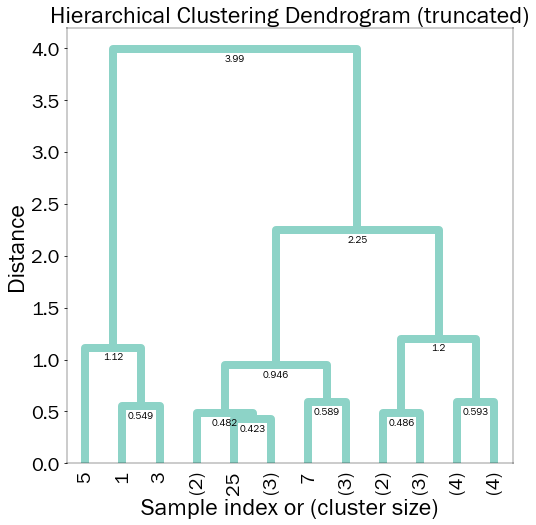

In [76]:
max_d = 5 # max_d as in max_distance
pl.rcParams['axes.titlesize'] = 24
pl.rcParams['axes.titleweight'] = 'bold'
pl.rcParams['axes.labelsize'] = 24
pl.rcParams['lines.linewidth'] = 8
pl.rcParams['xtick.labelsize'] = 20
pl.rcParams['ytick.labelsize'] = 20
pl.rcParams['figure.figsize'] = [8, 8]
pl.rcParams['axes.linewidth'] = 2
pl.rcParams['axes.edgecolor']  = "#00000033"

pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = 'Franklin Gothic Book'
cm = plt.get_cmap("Set3")
a =[matplotlib.colors.rgb2hex(c[:3]) for c in cm.colors]

hierarchy.set_link_color_palette(a)

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    above_threshold_color='grey',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)
plt.show()


# Assembling the codebook

In [77]:
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [94]:
K = 6
centers = sss
# clusters = fcluster(Z, max_d, criterion='distance')
clusters = fcluster(Z, K, criterion='maxclust')
print("Samples ", len(centers))
n_clusters = np.max(clusters)
print("Clusters found", n_clusters)
codebook = {}
for i in range(0, len(clusters)):
    cluster_id = clusters[i]
    if not cluster_id in codebook:
        codebook[cluster_id] = []
    codebook[cluster_id].append(centers[i])

# CALCULATE THE CENTROID    
for k in codebook:
    codeset = np.array(codebook[k])
    dist = np.sum(squareform(distance.pdist(codeset, metric=dtw2)), 0)
    clustroid = np.argmin(dist)
    codebook[k] = codeset[clustroid]

codebook = codebook.values()

Samples  9533
Clusters found 6


In [95]:

def visualize_codebook(sss):
    N = len(sss)
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 0.9, N)]


    fig, axs = pl.subplots(2, int(len(sss)/2 + 0.5), sharey=True)        
    axs = axs.reshape(-1)
    for i, ss in enumerate(sss):
    #     axs[i].set_ylim(0, 1)
        axs[i].set_title("Codeword %s"% i)
        ss = np.reshape(ss, WORD_SHAPE)
        for line in ss:
            axs[i].plot(line, color=colors[i])
#         print(ss.shape, WORD_SHAPE)
        axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs[i].get_xaxis().set_visible(False)
    plt.show()
    # plt.tight_layout()
#     fig = plt.gcf()

#     update = {'data':[{'fill': 'tozeroy'}]}  # this updates BOTH traces now
#     plotly_fig = tls.mpl_to_plotly( fig )
#     plotly_fig.update(update)
#     plotly_fig['layout']['title'] = BOOK.upper() + ' CODEWORDS'.upper()
#     plotly_fig['layout']['margin'].update({'t':40})

#     return py.iplot(plotly_fig, filename='codebook')
   

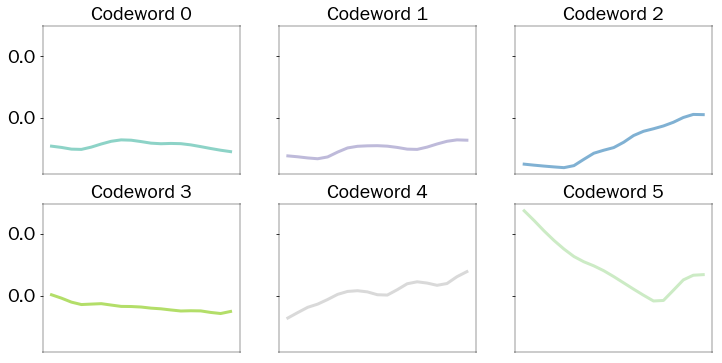

In [96]:
pl.rcParams['lines.linewidth'] = 3
pl.rcParams['figure.figsize'] = [12, 6]
visualize_codebook(codebook)

# Applying the codebook

In [97]:
activity = sss
cb = np.array(list(codebook))
print(cb.shape)

result = []
for i, window in enumerate(activity):
    codeword = np.argmin([dtw2(codeword, window) for codeword in cb])
    result.append(codeword + 1)          

(6, 19)


In [98]:
arr = np.array(result)
sizes = []
for i in range(0, len(BOUNDS)-1):
    start = BOUNDS[i]
    end = BOUNDS[i+1]
    sizes.append(end-start)
tn = max(sizes)

results = np.full((len(BOUNDS) - 1, tn), 0)



In [99]:

for u in results:
    kernel = 20
    smooth = []
    for i in np.arange(0, u.shape[0]):
        window = u[i:(i+kernel)]
        counts = np.bincount(window)
        smooth.append(np.argmax(counts))
#     print(len(smooth), smooth)
    results[u] = np.array(smooth)


In [100]:
def sparse_cue(r):
    r = r[np.nonzero(r)]
    sparse_result = []
    current = None
    width = 0
    for c in r:
        if current == None:
            current = c

        if current == c:
            width = width + 1
        else:
            sparse_result.append((current, width))
            current = c
            width = 1
    sparse_result.append((current, width))
    return sparse_result

sparse_results = list(map(sparse_cue, results))
results

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [101]:
u_freq = {}
for i in range(0, len(BOUNDS)-1):
    start = BOUNDS[i]
    end = BOUNDS[i+1]
    u_activity = arr[start:end]
    u_freq[USERS[i]] = freq(u_activity)
    results[i] = np.pad(u_activity, (0, tn - u_activity.shape[0]), 'constant')


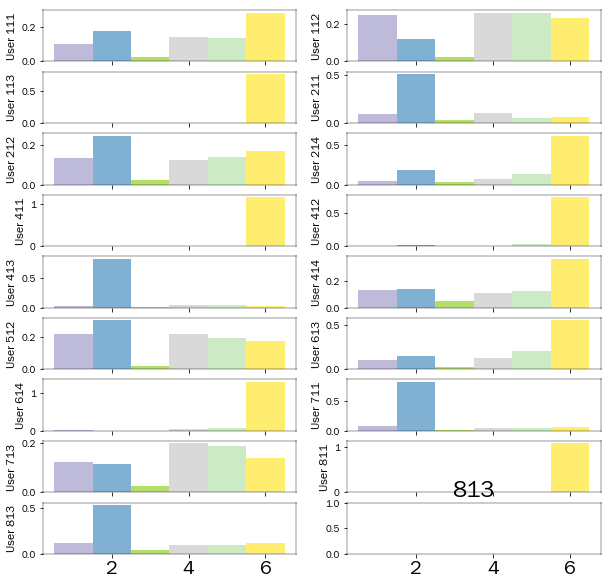

In [102]:
pl.rcParams['figure.figsize'] = [10, 10]
pl.rcParams['axes.titlesize'] = 24
pl.rcParams['axes.titleweight'] = 'bold'
pl.rcParams['axes.labelsize'] = 12
pl.rcParams['lines.linewidth'] = 8
pl.rcParams['xtick.labelsize'] = 20
pl.rcParams['ytick.labelsize'] = 10
pl.rcParams['axes.linewidth'] = 2
pl.rcParams['axes.edgecolor']  = "#00000033"
pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = 'Franklin Gothic Book'
visualize_codebook_freq(u_freq)


In [103]:
a = np.array([2,  15,   4,   8, 543,   3,  12,   2])
(a / sum(a))[6]

0.02037351443123939

In [104]:
a = [u_freq[u] for u in u_freq]
a = [i[1] for i in a]
a = [b[0]/sum(b) for b in a]
np.average(np.array(a))
np.std(np.array(a))

0.2242901945578252

In [105]:
u_freq_prop = []
for j, u in enumerate(u_freq):
    domain = u_freq[u][0]
    values = u_freq[u][1]
    f = np.zeros(K)
    for i in range(0, K):
        query = i+1
        idx = np.where(domain == query)
        if idx[0].shape[0] == 0:
            value = 0
        else: 
            f[i] = values[idx]
            
    start = BOUNDS[j]
    end = BOUNDS[j+1]
    n = end-start
    u_freq_prop.append(f/n)
    
    
codebook_frequencies = np.vstack(u_freq_prop)

In [106]:
def duo_cluster(cbf, group, level):
    tabs = ""
    t = level
    while t > 0:
        tabs = tabs + "\t"
        t = t - 1
        
    print(tabs, group.shape[0], "USERS", group)
    if group.shape[0] <= 2:
        return group
    
    CF = linkage(cbf, method='complete', metric="euclidean")
    clusters = fcluster(CF, 2, criterion='maxclust')
    g1 = np.where(clusters == 1)
    g2 = np.where(clusters == 2)
    if len(g1[0]) == len(group):
        return group
   
    
    u1 = group[g1]
    u2 = group[g2]

    cbf1 = codebook_frequencies[g1]
    cbf2 = codebook_frequencies[g2]

    return np.concatenate(np.array([duo_cluster(cbf1, u1, level + 1), duo_cluster(cbf2, u2, level+1)]))

        

In [107]:
ordering = duo_cluster(codebook_frequencies, USERS, 0)
sort_cbf = USERS.searchsorted(ordering)
ordered_cbf = codebook_frequencies[sort_cbf]


 17 USERS [111 112 113 211 212 214 411 412 413 414 512 613 614 711 713 811 813]
	 4 USERS [211 413 711 813]
		 2 USERS [413 711]
		 2 USERS [211 813]
	 13 USERS [111 112 113 212 214 411 412 414 512 613 614 713 811]
		 5 USERS [113 411 412 614 811]
			 4 USERS [113 411 412 811]
				 3 USERS [113 411 811]
				 1 USERS [412]
			 1 USERS [614]
		 8 USERS [111 112 212 214 414 512 613 713]
			 2 USERS [212 512]
			 6 USERS [111 112 214 414 613 713]
				 2 USERS [613 713]
				 4 USERS [111 112 214 414]
					 3 USERS [111 112 414]
					 1 USERS [214]


In [108]:


pl.rcParams['axes.labelsize'] = 20
pl.rcParams['lines.linewidth'] = 8
pl.rcParams['xtick.labelsize'] = 20
pl.rcParams['ytick.labelsize'] = 20
pl.rcParams['figure.figsize'] = [16, 6]
pl.rcParams['axes.linewidth'] = 2
pl.rcParams['axes.edgecolor']  = "#00000033"
pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = 'Franklin Gothic Book'
pl.rcParams['axes.titlesize'] = 20
pl.rcParams['axes.titleweight'] = 'bold'

def make_codebook_viz(transposed=False):
    
    
    data = results[sort_cbf]
    labels= ordering
    T=np.arange(len(labels))
    t_max = int((data.shape[1] / 2 * 5 / 60))
    if transposed:
        fig = pl.figure(figsize=(6, 16))
        ax = pl.gca()
        data = np.transpose(data)
        ax.set_xticks(T)
        ax.set_xticklabels([], fontsize = 10)
        ax.set_xlabel("User")
        
        
        ax.set_ylabel("Time (min)")
        xn = len(list(ax.get_yticklabels())) + 2
        ylabels = np.linspace(0, t_max, xn)
        ylabels = np.insert(ylabels, 0, 0)
        ax.set_yticklabels(np.round(ylabels))
        
    else:
        fig = pl.figure(figsize=(16, 6))
        ax = pl.gca()
        ax.set_yticks(T)
        ax.set_yticklabels(labels)
        ax.set_ylabel("User")
        ax.set_xlabel("Time (min)")
        
        xn = len(list(ax.get_xticklabels())) + 2
        xlabels = np.linspace(0, t_max, xn)
        xlabels = np.insert(xlabels, 0, 0)
        ax.set_xticklabels(np.round(xlabels))
        
    
    title = "%s Codebook (K=%i, WIN=%.1f s)"%(BOOK, K, WINDOW_SIZE)
    title = title.upper()
    ax.set_title(title, fontname="Franklin Gothic Medium")
    
    ax.imshow(data, cmap=COLOR_MP, interpolation='nearest', aspect='auto')

    pl.show()



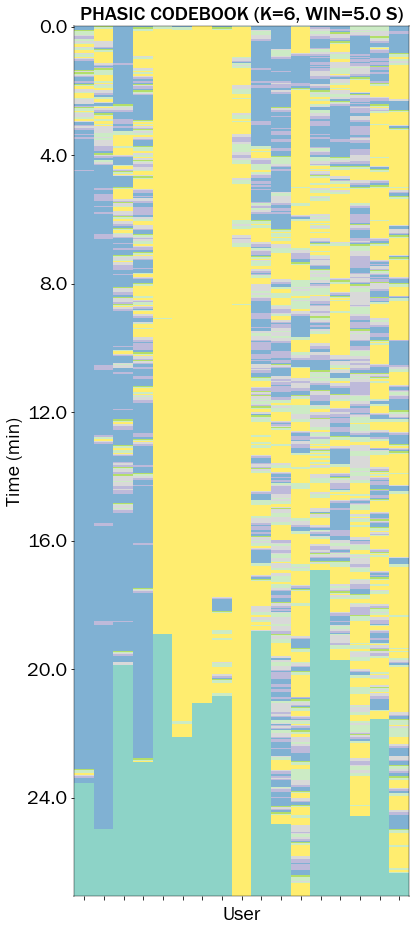

In [109]:
make_codebook_viz(True)


In [612]:
a = np.linspace(0, 26, 8)
a = np.insert(a, 0, 0)
a.shape

(9,)

In [459]:
# make_vtt(USERS[0], sparse_results[0])
for i, u in enumerate(USERS):
    make_vtt(u, sparse_results[i], BOOK)


File saved! irb/111/motion_111.vtt
File saved! irb/112/motion_112.vtt
File saved! irb/113/motion_113.vtt
File saved! irb/211/motion_211.vtt
File saved! irb/212/motion_212.vtt
File saved! irb/214/motion_214.vtt
File saved! irb/411/motion_411.vtt
File saved! irb/412/motion_412.vtt
File saved! irb/413/motion_413.vtt
File saved! irb/414/motion_414.vtt
File saved! irb/512/motion_512.vtt
File saved! irb/613/motion_613.vtt
File saved! irb/614/motion_614.vtt
File saved! irb/711/motion_711.vtt
File saved! irb/713/motion_713.vtt
File saved! irb/811/motion_811.vtt
File saved! irb/813/motion_813.vtt


# Save for Qual Review

Need to run this in the codewords directory to have scrubbable video.
`npm install http-server -g
http-server -p 8000`


In [151]:
query = [
   (0, 100), 
   (200, 350)
]
q = json.dumps(query)
from IPython.core.display import display, HTML
display(HTML('<h1 id="data" data="%s">data</h1>'%q))

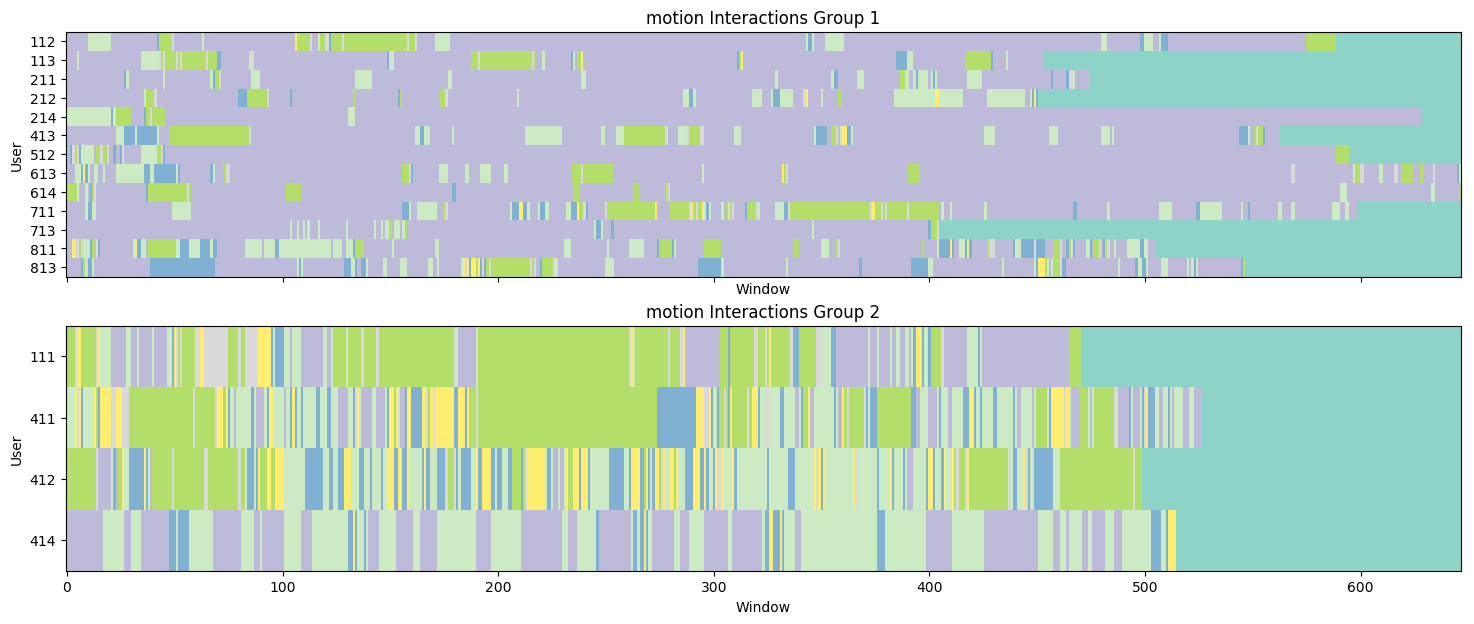

In [341]:
def plot_group(ax, group, title):
    ax.imshow(results[group], cmap='Set3', interpolation='nearest', aspect='auto')
    ax.set_title(title)
    ax.set_ylabel("User")
    ax.set_xlabel("Window")
    labels= USERS[group]
    T=np.arange(len(labels))
    ax.set_yticks(T)
    ax.set_yticklabels(labels)
    
pl.rcParams['figure.figsize'] = [18, 7]
fig, axs = pl.subplots(2, 1, sharex=True)   
plot_group(axs[0], g1, "%s Interactions Group 1"%(BOOK))
plot_group(axs[1], g2, "%s Interactions Group 2"%(BOOK))
# plot_group(axs[2], g3, "%s Interactions Group 2"%(BOOK))
pl.show()

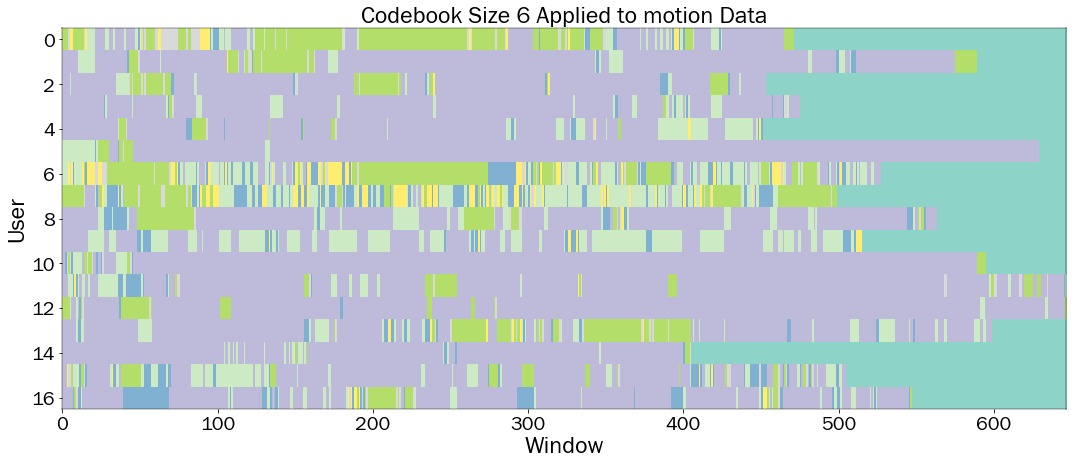

[111 112 113 211 212 214 411 412 413 414 512 613 614 711 713 811 813]


In [333]:
pl.rcParams['figure.figsize'] = [18, 7]
pl.imshow(results, cmap='Set3', interpolation='nearest', aspect='auto')
pl.title("Codebook Size %s Applied to %s Data"%(K, BOOK))
pl.ylabel("User")
pl.xlabel("Window")
pl.show()
print(USERS)

In [ ]:

CF = linkage(codebook_frequencies, method='complete', metric="euclidean")
fancy_dendrogram(
    CF,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)

plt.title(BOOK + ' Codebook Frequency Clusters')
plt.xlabel('Users')
plt.ylabel('Distance')
        
plt.show()

clusters = fcluster(CF, 2, criterion='maxclust')
print(clusters)
g1 = np.where(clusters == 1)
g2 = np.where(clusters == 2)
# g3 = np.where(clusters == 3)

cf1 = np.mean(codebook_frequencies[g1], 0)
cf2 = np.mean(codebook_frequencies[g2], 0)
# cf3 = np.mean(codebook_frequencies[g3], 0)
print("GROUP 1", USERS[g1], cf1)
print("GROUP 2", USERS[g2], cf2)
# print("GROUP 3", USERS[g3], cf3)

diff = (cf2-cf1) * 100

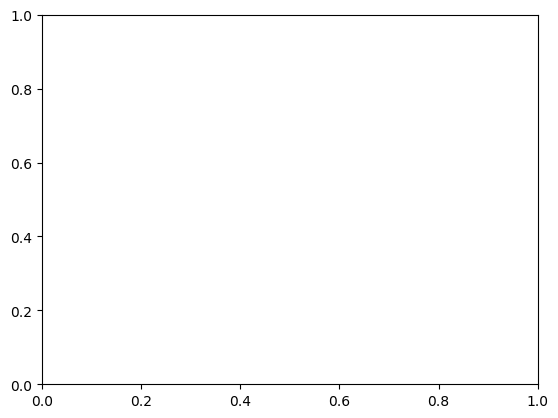

In [340]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

# # Example data
# N = len(diff)
# cm = plt.get_cmap("Set3")
# colors = [cm(i) for i in np.linspace(0, 1, N+1)]

# y_pos = np.arange(len(diff))
# error = np.random.rand(len(people))
# for i in range(N):
#     ax.barh(y_pos[i], diff[i], color=colors[i+1])
# # ax.set_yticks(y_pos)
# # ax.set_yticklabels(people)
# # ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Difference(%)')
# ax.set_xlim(-100, 100)
# ax.set_ylabel('Codeword')
# # ax.set_title('How fast do you want to go today?')

# plt.show()

In [394]:
%%javascript
require.config({
  paths: {
      jquery: 'https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js',
      underscore: 'lib/underscore.js'
  }
});

<IPython.core.display.Javascript object>

In [395]:
%%HTML
<style>
    video{
        border: 2px solid #333;
    }
   
    #captions{
        width: 100%;
        text-align: center;
        font-size: 2em;
        padding: 1em;
    }
</style>

In [396]:
%%HTML
<div id="captions"></div>
<video width="100%" height="400" controls>
    <source src="http://localhost:8000/irb/111/data/screen_111_opt.mp4" type="video/mp4" controls>
    <track kind="subtitles" label="English subtitles" src="irb/111/acc.vtt" srclang="en" default></track>
</video>
<div id="transcript">
From retrospective think aloud
</div>

In [397]:
%%javascript
var textTrack = $('video')[0].textTracks[0]
textTrack.mode = "hidden"
for(var j = 0; j < textTrack.cues.length; ++j){
    var cue = textTrack.cues[j];
    if(! cue.data){
        cue.data = JSON.parse(cue.text);
        cue.text = cue.data.code;
    }
}

textTrack.oncuechange = function (){
    var myCues = this.activeCues;
    _.each(myCues, function(cue){
        $('#captions').html(cue.data.code).css('background', cue.data.color);
    })
}


var a;
a = JSON.parse($('#data').attr('data'))

$('.qual').remove()
_.each(a, function(item, i){
    var start = item[0]
    var end = item[1]
    var play_button = $('<button>').addClass("qual").html(i + " Segment").attr({
            start: start,
            end: end
    }).click(function(e){
            var s = parseFloat($(this).attr('start'))
            var e = parseFloat($(this).attr('end'))
            var vid = $('video')[0]
            console.log("Setting time to ", s)
            vid.currentTime = s
            vid.play()
    })
   $('video').parent().append(play_button)
   console.log()
});


<IPython.core.display.Javascript object>

# Notes

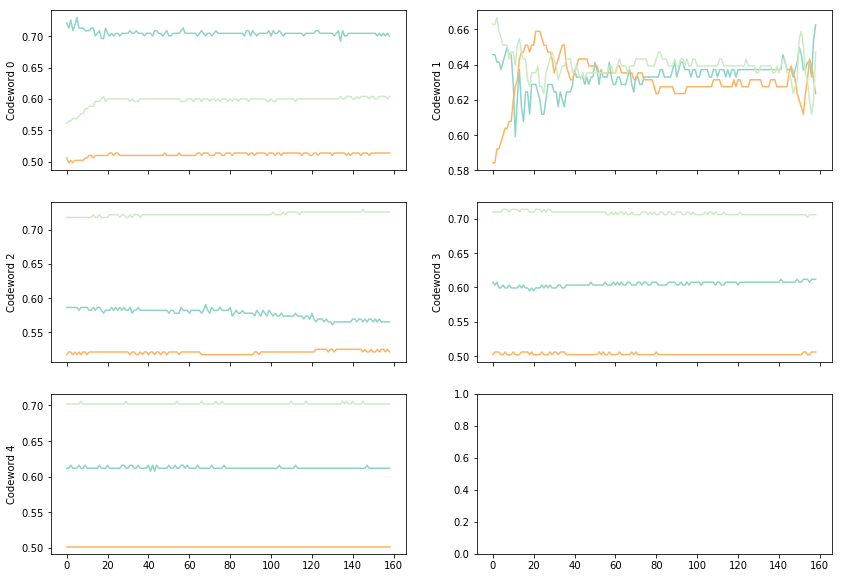

In [153]:
cb = np.array(list(codebook))
visualize_codebook(cb, subplot=True)

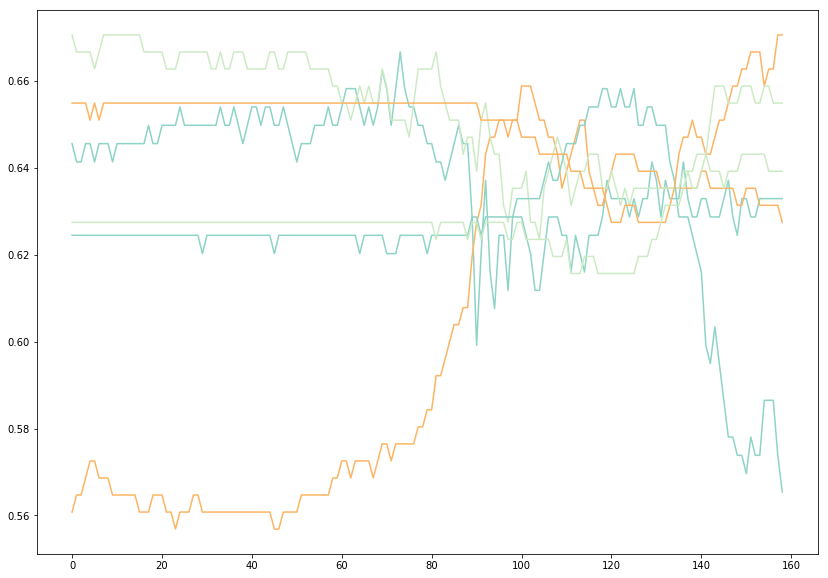

In [112]:
a = sss[0]
b = sss[10]
d2 = DTWDistance2D(a, b)
visualize_codebook([a, b], subplot=False)



In [113]:
def sample_kcenters(words, kcenters, cull_threshold=100):
#     print("WORDS", words.shape[0], "CENTERS", len(kcenters))
    
    if len(words) <= 1: 
        return np.array(kcenters)
    
    n = words.shape[0]
    dist = [dtw2(kcenters[-1], words[i]) for i in range(0, n)]
    dists = np.array(dist)
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    cull_at = np.argmax(dists>cull_threshold)
    
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    
    return np.array(sample_kcenters(words, kcenters))